## Parse panel data files from years 8-11 (day granularity)

In [1]:
import pandas as pd
from pandas.core.series import Series
import numpy as np
import glob
import datetime

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def convert_week(x):
    start_epoch_arr= x.values.astype(int)
    end_epoch_arr= np.array(start_epoch_arr)
    
    start_epoch_arr= (start_epoch_arr-400)*7+31900-6
    start_epoch_arr = (start_epoch_arr-25569) * 86400
    
    end_epoch_arr = (end_epoch_arr-400)*7+31900
    end_epoch_arr= (end_epoch_arr-25569) * 86400
    
    return (start_epoch_arr, end_epoch_arr)

def get_transaction_time(x, start_epoch_arr):
    transaction_time_epoch_arr= x.values.astype(int)
    transaction_time_epoch_arr= start_epoch_arr + (transaction_time_epoch_arr * 60)
    return transaction_time_epoch_arr

def get_datetime(transaction_time_epoch_arr):
    t_shape= np.shape(transaction_time_epoch_arr)
    month_arr= np.zeros(t_shape, dtype=int)
    day_arr=np.zeros(t_shape, dtype=int)
    year_arr= np.zeros(t_shape, dtype=int)
    hour_arr= np.zeros(t_shape, dtype=int)
    minute_arr= np.zeros(t_shape, dtype=int)
    dayofweek_arr= np.zeros(t_shape, dtype=int)
    week_num_arr= np.zeros(t_shape, dtype=int)
    
    for i in xrange(t_shape[0]):
        t_time= transaction_time_epoch_arr[i]
        dt= datetime.datetime.utcfromtimestamp(t_time)
        month_arr[i]= dt.month
        day_arr[i]= dt.day
        year_arr[i]= dt.year
        hour_arr[i]= dt.hour
        minute_arr[i]= dt.minute
        dayofweek_arr[i]= dt.weekday()
        week_num_arr[i]= dt.isocalendar()[1]
    
    return (month_arr, day_arr, year_arr, hour_arr, minute_arr, dayofweek_arr, week_num_arr)

def parse_colupc(colupc_arr):
    t_shape= np.shape(colupc_arr)
    sy_arr= np.zeros(t_shape, dtype=int)
    ge_arr=np.zeros(t_shape, dtype=int)
    vend_arr= np.zeros(t_shape, dtype=int)
    item_arr= np.zeros(t_shape, dtype=int)
    for i, colupc in enumerate(colupc_arr):
        assert len(colupc) == 13
        # sy, gen, vend, item
        m_as= [colupc[:2], colupc[2:3], colupc[3:8], colupc[8:]]
        m_outs= [sy_arr, ge_arr, vend_arr, item_arr]
        for j in xrange(4):
            a= m_as[j]
            out= m_outs[j]
            out[i]= int(a)
    return (sy_arr, ge_arr, vend_arr, item_arr)

def parse_panel(filename):
    column_headers= None
    m_df_items= []
#     m_df = pd.read_csv(filename, engine='python')
    with open(filename) as f:
        i= 0
        for line in f:
            line= line.strip()
            s_arr= line.split(",")
            s_arr= [x.strip() for x in s_arr if len(x.strip()) > 0]
            if column_headers == None:
                column_headers= s_arr
                continue
            item= (i, s_arr)
            m_df_items.append(item)
            i+=1

    #if "MINUTE" not in m_df.columns.values.tolist():
    if "MINUTE" not in column_headers:
        raise RuntimeError("Expecting MINUTE column in dataset, unable to parse")
        
    m_df= pd.DataFrame.from_items(m_df_items, columns=column_headers, orient='index')
    
    s_week_df= m_df["WEEK"]
    start_time_epoch_arr, end_time_epoch_arr= convert_week(s_week_df)
    r1= pd.DataFrame({
        'START_TIME_EPOCH_S' : start_time_epoch_arr
    })
    r2= pd.DataFrame({
        'END_TIME_EPOCH_S' : end_time_epoch_arr
    })
    m_df= pd.concat([m_df, r1, r2], axis=1)
    #
    s_minute_df= m_df["MINUTE"]
    transaction_time_epoch_arr= get_transaction_time(s_minute_df, start_time_epoch_arr)
    t_result= pd.DataFrame({
        'TRANSACTION_TIME_EPOCH_S' : transaction_time_epoch_arr
    })
    # extract month, day, year, hour, minute
    month_arr, day_arr, year_arr, hour_arr, minute_arr, dayofweek_arr, week_num_arr= get_datetime(transaction_time_epoch_arr)
    r1= pd.DataFrame({
        'MONTH' : month_arr
    })
    r2= pd.DataFrame({
        'DAY' : day_arr
    })
    r3= pd.DataFrame({
        'YEAR' : year_arr
    })
    r4= pd.DataFrame({
        'HOUR_OF_DAY' : hour_arr
    })
    r5= pd.DataFrame({
        'MINUTE' : minute_arr
    })
    r6= pd.DataFrame({
        'DAYOFWEEK' : dayofweek_arr
    })
    r7= pd.DataFrame({
        'WEEKNUM' : week_num_arr
    })
    m_df.drop("MINUTE", axis=1, inplace=True)
    m_df= pd.concat([m_df, t_result, r1, r2, r3, r4, r5, r6, r7], axis=1)
    
    # Parse COLUPC to SY GE VEND ITEM
    # 18417375121 ->   
    #  item: 75121
    #  vender: 84173
    #  generation: 1
    #  system: 00 (zero padded)
    s_colupc_df= m_df["COLUPC"]
    sy_arr, ge_arr, vend_arr, item_arr = parse_colupc(s_colupc_df)
    r1= pd.DataFrame({
        'SY' : sy_arr
    })
    r2= pd.DataFrame({
        'GE' : ge_arr
    })
    r3= pd.DataFrame({
        'VEND' : vend_arr
    })
    r4= pd.DataFrame({
        'ITEM' : item_arr
    })
    m_df= pd.concat([m_df, r1, r2, r3, r4], axis=1)
    
    return m_df

In [4]:
beer_dir='/home/dyerke/Documents/DSE/DSE220/HW4_Final/data'

# parse panels across Year8-Year11
panel_filenames= []
panel_filenames.extend(glob.glob(beer_dir+"/Year8/*.DAT"))
panel_filenames.extend(glob.glob(beer_dir+"/Year9/*.DAT"))
panel_filenames.extend(glob.glob(beer_dir+"/Year10/*.DAT"))
panel_filenames.extend(glob.glob(beer_dir+"/Year11/*.DAT"))

master_panel_df= None
for pf in panel_filenames:
    print "Parsing {}".format(pf)
    m_df= parse_panel(pf)
    if master_panel_df is None:
        master_panel_df= m_df
    else:
        master_panel_df= pd.concat([master_panel_df, m_df], ignore_index=True)

master_panel_df.sort(["TRANSACTION_TIME_EPOCH_S"], inplace=True)
master_panel_df.reset_index(drop=True, inplace=True)
master_panel_df

Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year8/beer_PANEL_MK_1479_1530.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year8/beer_PANEL_GK_1479_1530.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year8/beer_PANEL_KK_1479_1530.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year9/beer_PANEL_GK_1531_1582.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year9/beer_PANEL_MK_1531_1582.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year10/beer_PANEL_MK_1583_1634.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year10/beer_PANEL_GK_1583_1634.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year10/beer_PANEL_DK_1583_1634.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year11/beer_PANEL_DK_1635_1686.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year11/beer_PANEL_GK_1635_1686.DAT
Parsing /home/dyerke/Documents/DSE/DSE220/HW4_Final/data/Year11/beer_PANEL_MK_1635_16

,PANID,WEEK,UNITS,OUTLET,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,...,DAY,YEAR,HOUR_OF_DAY,MINUTE,DAYOFWEEK,WEEKNUM,SY,GE,VEND,ITEM
0,3369595,1479,4,GK,10,257871,0018417375121,1199059200,1199577600,1199092980,...,31,2007,9,23,0,1,0,1,84173,75121
1,3834697,1479,1,GK,8.99,257871,0013410017636,1199059200,1199577600,1199094480,...,31,2007,9,48,0,1,0,1,34100,17636
2,3308189,1479,1,GK,14.68,9999690,0011820053168,1199059200,1199577600,1199095200,...,31,2007,10,0,0,1,0,1,18200,53168
3,3812222,1479,1,GK,10.98,9999691,0013410057340,1199059200,1199577600,1199095440,...,31,2007,10,4,0,1,0,1,34100,57340
4,3356188,1479,1,GK,8.89,9999691,0017199030069,1199059200,1199577600,1199096700,...,31,2007,10,25,0,1,0,1,71990,30069
5,3315523,1479,1,GK,14.68,9999690,0013410057306,1199059200,1199577600,1199097180,...,31,2007,10,33,0,1,0,1,34100,57306
6,3341818,1479,1,GK,10.99,257871,0011820096418,1199059200,1199577600,1199098380,...,31,2007,10,53,0,1,0,1,18200,96418
7,3334490,1479,1,GK,7.49,9999691,0028066095605,1199059200,1199577600,1199099460,...,31,2007,11,11,0,1,0,2,80660,95605
8,3358846,1479,1,GK,6.19,9999690,0018417330130,1199059200,1199577600,1199099520,...,31,2007,11,12,0,1,0,1,84173,30130
9,3358846,1479,1,GK,5.99,9999690,0018417332130,1199059200,1199577600,1199099520,...,31,2007,11,12,0,1,0,1,84173,32130


In [5]:
s_outlet= master_panel_df["OUTLET"]
s_outlet_counts= s_outlet.value_counts()
s_outlet_counts

GK    67891
DK       26
MK       25
KK       23
dtype: int64

In [6]:
# decompose outlet categories to 0=Grocery, 1=Drug, 2=Mass, 3=KK?
mapping= {
    "GK":0,
    "DK":1,
    "MK":2,
    "KK":3,
}
master_panel_df["OUTLET"]= s_outlet.apply(lambda x: mapping[x.strip()])
master_panel_df

,PANID,WEEK,UNITS,OUTLET,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,...,DAY,YEAR,HOUR_OF_DAY,MINUTE,DAYOFWEEK,WEEKNUM,SY,GE,VEND,ITEM
0,3369595,1479,4,0,10,257871,0018417375121,1199059200,1199577600,1199092980,...,31,2007,9,23,0,1,0,1,84173,75121
1,3834697,1479,1,0,8.99,257871,0013410017636,1199059200,1199577600,1199094480,...,31,2007,9,48,0,1,0,1,34100,17636
2,3308189,1479,1,0,14.68,9999690,0011820053168,1199059200,1199577600,1199095200,...,31,2007,10,0,0,1,0,1,18200,53168
3,3812222,1479,1,0,10.98,9999691,0013410057340,1199059200,1199577600,1199095440,...,31,2007,10,4,0,1,0,1,34100,57340
4,3356188,1479,1,0,8.89,9999691,0017199030069,1199059200,1199577600,1199096700,...,31,2007,10,25,0,1,0,1,71990,30069
5,3315523,1479,1,0,14.68,9999690,0013410057306,1199059200,1199577600,1199097180,...,31,2007,10,33,0,1,0,1,34100,57306
6,3341818,1479,1,0,10.99,257871,0011820096418,1199059200,1199577600,1199098380,...,31,2007,10,53,0,1,0,1,18200,96418
7,3334490,1479,1,0,7.49,9999691,0028066095605,1199059200,1199577600,1199099460,...,31,2007,11,11,0,1,0,2,80660,95605
8,3358846,1479,1,0,6.19,9999690,0018417330130,1199059200,1199577600,1199099520,...,31,2007,11,12,0,1,0,1,84173,30130
9,3358846,1479,1,0,5.99,9999690,0018417332130,1199059200,1199577600,1199099520,...,31,2007,11,12,0,1,0,1,84173,32130


In [7]:
master_panel_df[master_panel_df['OUTLET'] == 1].groupby('PANID').get_group("3107334")
#master_panel_df[master_panel_df['OUTLET'] == 1].groupby('PANID').describe()

,PANID,WEEK,UNITS,OUTLET,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,...,DAY,YEAR,HOUR_OF_DAY,MINUTE,DAYOFWEEK,WEEKNUM,SY,GE,VEND,ITEM
45809,3107334,1619,1,1,7.99,651444,0013410057636,1283731200,1284249600,1284299280,...,12,2010,13,48,6,36,0,1,34100,57636
53657,3107334,1644,1,1,8.61,651444,0013410057636,1298851200,1299369600,1299336540,...,5,2011,14,49,5,9,0,1,34100,57636
55790,3107334,1651,1,1,8.99,651444,0013410057636,1303084800,1303603200,1303658160,...,24,2011,15,16,6,16,0,1,34100,57636
60228,3107334,1663,1,1,9.49,651444,0013410057636,1310342400,1310860800,1310494020,...,12,2011,18,7,1,28,0,1,34100,57636


In [8]:
master_panel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67965 entries, 0 to 67964
Data columns (total 21 columns):
PANID                       67965 non-null object
WEEK                        67965 non-null object
UNITS                       67965 non-null object
OUTLET                      67965 non-null int64
DOLLARS                     67965 non-null object
IRI_KEY                     67965 non-null object
COLUPC                      67965 non-null object
START_TIME_EPOCH_S          67965 non-null int64
END_TIME_EPOCH_S            67965 non-null int64
TRANSACTION_TIME_EPOCH_S    67965 non-null int64
MONTH                       67965 non-null int64
DAY                         67965 non-null int64
YEAR                        67965 non-null int64
HOUR_OF_DAY                 67965 non-null int64
MINUTE                      67965 non-null int64
DAYOFWEEK                   67965 non-null int64
WEEKNUM                     67965 non-null int64
SY                          67965 non-null int64
GE 

In [9]:
master_panel_df.to_csv("master_panel.csv")

# Clean data and join panel dataframe with drug and groc data for promotion information

In [10]:
master_panel_dict= {}
for row in master_panel_df.iterrows():
    row= row[1]
    week= str(row['WEEK'])
    iri= str(row['IRI_KEY'])
    sy= str (row['SY'])
    ge= str(row['GE'])
    vend= str(row['VEND'])
    item= str(row['ITEM'])
    m_key= (week, iri, sy, ge, vend, item)
#     if m_key in master_panel_dict:
#         raise RuntimeError("{} present in dictionary".format(m_key))
    master_panel_dict[m_key]= 0

test_key= ('1479', '257871', '0', '1', '84173', '75121')
print master_panel_dict[test_key]
print len(master_panel_dict)

0
47711


In [11]:
### WARNING: This cell takes a long time to run.

# for each line of store data
    # split by whitespace
    # choose fields iri_key, week, sy, ge, vend, item, f, d, pr
    # 0-5, 8-10

beer_drug_filenames= []
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year8/beer_drug*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year8/beer_groc*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year9/beer_drug*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year9/beer_groc*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year10/beer_drug*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year10/beer_groc*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year11/beer_drug*"))
beer_drug_filenames.extend(glob.glob(beer_dir+"/Year11/beer_groc*"))

for f in beer_drug_filenames:
    with open(f) as openfile:
        i = 0
        vals= None
        for line in openfile:
            if i != 0:
                try:
                    vals = line.strip().split(' ')
                    vals = [x.strip() for x in vals if len(x.strip()) > 0]
                    week = vals[1]
                    iri_key = vals[0]
                    sy = vals[2]
                    ge = vals[3]
                    vend = vals[4]
                    item = vals[5]
                    f = vals[8]
                    d = vals[9]
                    pr = vals[10]
                    m_key = (week, iri_key, sy, ge, vend, item)
                    if m_key not in master_panel_dict:
                        continue
                    assert master_panel_dict[m_key] == 0 
                    master_panel_dict[m_key] = (f, d, pr)
                except Exception, e:
                    print len(vals), vals
                    raise RuntimeError("Error while parsing file {} linenum={}, line={}".format(openfile, i, line))
            i += 1

In [12]:
print len(master_panel_dict)
test_key= ('1479', '257871', '0', '1', '84173', '75121')
print master_panel_dict[test_key]

47711
('NONE', '0', '0')


In [13]:
m_df_items= []
i =0
for k,v in master_panel_dict.iteritems():
    m_arr= []
    m_arr.extend(k)
    if type(v) == int:
        v= (np.NAN, np.NAN, np.NAN)
    m_arr.extend(v)
    m_df_items.append((i, m_arr))
    i += 1

# test_key= ('1479', '257871', '0', '1', '84173', '75121')
column_headers= ['WEEK', 'IRI_KEY', 'SY', 'GE', 'VEND', "ITEM", "F", 'D', "PR"]
m_df= pd.DataFrame.from_items(m_df_items, columns=column_headers, orient='index')
m_df

,WEEK,IRI_KEY,SY,GE,VEND,ITEM,F,D,PR
0,1498,9999879,0,1,88345,10053,NaN,NaN,NaN
1,1662,9999879,0,1,72890,158,NaN,NaN,NaN
2,1673,9999690,0,1,80660,95937,NaN,NaN,NaN
3,1482,9999690,0,1,84173,31130,NaN,NaN,NaN
4,1480,9999691,0,1,18200,53168,NaN,NaN,NaN
5,1584,257871,0,1,34100,57306,NONE,1,1
6,1654,1085053,0,1,71990,48,NONE,0,0
7,1519,9999879,7,5,4563,13,NaN,NaN,NaN
8,1664,9999661,0,1,84173,37,NaN,NaN,NaN
9,1605,9999879,0,1,87692,97102,NaN,NaN,NaN


In [14]:
# if Nan found in column for F, D, PR => assume Unknown
# NOTE: investigation was made into the use of chains info and masked chain info (see Section 3.6 in the PDF)
# however, after evaluation, it was determined that a promotion done in one store would not apply for one
# in a different Geographic location

columns= ['F','D','PR']
replace= ['UNKNOWN','-1','-1']
for i in xrange(3):
    c= columns[i]
    r= replace[i]
    m_mask= pd.isnull(m_df[c])
    m_df[c][m_mask]= r

m_df

,WEEK,IRI_KEY,SY,GE,VEND,ITEM,F,D,PR
0,1498,9999879,0,1,88345,10053,UNKNOWN,-1,-1
1,1662,9999879,0,1,72890,158,UNKNOWN,-1,-1
2,1673,9999690,0,1,80660,95937,UNKNOWN,-1,-1
3,1482,9999690,0,1,84173,31130,UNKNOWN,-1,-1
4,1480,9999691,0,1,18200,53168,UNKNOWN,-1,-1
5,1584,257871,0,1,34100,57306,NONE,1,1
6,1654,1085053,0,1,71990,48,NONE,0,0
7,1519,9999879,7,5,4563,13,UNKNOWN,-1,-1
8,1664,9999661,0,1,84173,37,UNKNOWN,-1,-1
9,1605,9999879,0,1,87692,97102,UNKNOWN,-1,-1


In [15]:
m_df['SY'] = m_df['SY'].astype(int)
m_df['GE'] = m_df['GE'].astype(int)
m_df['VEND'] = m_df['VEND'].astype(int)
m_df['ITEM'] = m_df['ITEM'].astype(int)
m_df['D'] = m_df['D'].astype(int)
m_df['PR'] = m_df['PR'].astype(int)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47711 entries, 0 to 47710
Data columns (total 9 columns):
WEEK       47711 non-null object
IRI_KEY    47711 non-null object
SY         47711 non-null int64
GE         47711 non-null int64
VEND       47711 non-null int64
ITEM       47711 non-null int64
F          47711 non-null object
D          47711 non-null int64
PR         47711 non-null int64
dtypes: int64(6), object(3)

In [16]:
master_merged_df = pd.merge(master_panel_df, m_df, on=['WEEK', 'IRI_KEY','SY', 'GE', 'VEND','ITEM'])
master_merged_df

,PANID,WEEK,UNITS,OUTLET,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,...,MINUTE,DAYOFWEEK,WEEKNUM,SY,GE,VEND,ITEM,F,D,PR
0,3369595,1479,4,0,10,257871,0018417375121,1199059200,1199577600,1199092980,...,23,0,1,0,1,84173,75121,NONE,0,0
1,3369595,1479,3,0,7.5,257871,0018417375121,1199059200,1199577600,1199197080,...,18,1,1,0,1,84173,75121,NONE,0,0
2,3369595,1479,4,0,10,257871,0018417375121,1199059200,1199577600,1199464740,...,39,4,1,0,1,84173,75121,NONE,0,0
3,3834697,1479,1,0,8.99,257871,0013410017636,1199059200,1199577600,1199094480,...,48,0,1,0,1,34100,17636,NONE,0,0
4,3308189,1479,1,0,14.68,9999690,0011820053168,1199059200,1199577600,1199095200,...,0,0,1,0,1,18200,53168,UNKNOWN,-1,-1
5,3176552,1479,1,0,14.68,9999690,0011820053168,1199059200,1199577600,1199461680,...,48,4,1,0,1,18200,53168,UNKNOWN,-1,-1
6,3176552,1479,1,0,14.68,9999690,0011820053168,1199059200,1199577600,1199540940,...,49,5,1,0,1,18200,53168,UNKNOWN,-1,-1
7,3308189,1479,1,0,14.68,9999690,0011820053168,1199059200,1199577600,1199611620,...,27,6,1,0,1,18200,53168,UNKNOWN,-1,-1
8,3812222,1479,1,0,10.98,9999691,0013410057340,1199059200,1199577600,1199095440,...,4,0,1,0,1,34100,57340,UNKNOWN,-1,-1
9,3356188,1479,1,0,8.89,9999691,0017199030069,1199059200,1199577600,1199096700,...,25,0,1,0,1,71990,30069,UNKNOWN,-1,-1


In [17]:
master_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67965 entries, 0 to 67964
Data columns (total 24 columns):
PANID                       67965 non-null object
WEEK                        67965 non-null object
UNITS                       67965 non-null object
OUTLET                      67965 non-null int64
DOLLARS                     67965 non-null object
IRI_KEY                     67965 non-null object
COLUPC                      67965 non-null object
START_TIME_EPOCH_S          67965 non-null int64
END_TIME_EPOCH_S            67965 non-null int64
TRANSACTION_TIME_EPOCH_S    67965 non-null int64
MONTH                       67965 non-null int64
DAY                         67965 non-null int64
YEAR                        67965 non-null int64
HOUR_OF_DAY                 67965 non-null int64
MINUTE                      67965 non-null int64
DAYOFWEEK                   67965 non-null int64
WEEKNUM                     67965 non-null int64
SY                          67965 non-null int64
GE 

In [18]:
master_merged_df.to_csv("master_merged_panel.csv", index=False)

---
# Continue Cleaning Data


In [19]:
# Drop grocery and mass store types
# There are not enough stores of these types to do proper analysis
m_mask= master_merged_df["OUTLET"] == 0
master_merged_df= master_merged_df[m_mask]
master_merged_df.drop(["OUTLET"], inplace=True, axis=1)
master_merged_df

/home/dyerke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame


,PANID,WEEK,UNITS,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,MONTH,...,MINUTE,DAYOFWEEK,WEEKNUM,SY,GE,VEND,ITEM,F,D,PR
0,3369595,1479,4,10,257871,0018417375121,1199059200,1199577600,1199092980,12,...,23,0,1,0,1,84173,75121,NONE,0,0
1,3369595,1479,3,7.5,257871,0018417375121,1199059200,1199577600,1199197080,1,...,18,1,1,0,1,84173,75121,NONE,0,0
2,3369595,1479,4,10,257871,0018417375121,1199059200,1199577600,1199464740,1,...,39,4,1,0,1,84173,75121,NONE,0,0
3,3834697,1479,1,8.99,257871,0013410017636,1199059200,1199577600,1199094480,12,...,48,0,1,0,1,34100,17636,NONE,0,0
4,3308189,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199095200,12,...,0,0,1,0,1,18200,53168,UNKNOWN,-1,-1
5,3176552,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199461680,1,...,48,4,1,0,1,18200,53168,UNKNOWN,-1,-1
6,3176552,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199540940,1,...,49,5,1,0,1,18200,53168,UNKNOWN,-1,-1
7,3308189,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199611620,1,...,27,6,1,0,1,18200,53168,UNKNOWN,-1,-1
8,3812222,1479,1,10.98,9999691,0013410057340,1199059200,1199577600,1199095440,12,...,4,0,1,0,1,34100,57340,UNKNOWN,-1,-1
9,3356188,1479,1,8.89,9999691,0017199030069,1199059200,1199577600,1199096700,12,...,25,0,1,0,1,71990,30069,UNKNOWN,-1,-1


In [20]:
def hot1_encoding(df, index):
    print "\nApplying Hot 1 encoding method to column {}".format(index)
    #
    s= df[index]
    new_df= df
    #
    m_value_counts= s.value_counts()
    print "m_value_counts={}".format(m_value_counts)

    for k,v in m_value_counts.iteritems():
        uv_mask= (df[index] == k).astype(float)
        new_field= "Field_sourceCol_{}_value_{}".format(index, k)
        new_df[new_field]= uv_mask

    del new_df[index]

In [21]:
#
# manage'F' and 'D' column, which contains enumerations
#
s_f= master_merged_df['F']
s_f.value_counts()

UNKNOWN    46373
NONE       19968
A            940
B            470
C            109
A+            31
dtype: int64

In [22]:
s_d= master_merged_df['D']
s_d.value_counts()

-1    46373
 0    16982
 1     3999
 2      537
dtype: int64

In [23]:
hot1_encoding(master_merged_df, 'F')


Applying Hot 1 encoding method to column F
m_value_counts=UNKNOWN    46373
NONE       19968
A            940
B            470
C            109
A+            31
dtype: int64


In [24]:
master_merged_df

,PANID,WEEK,UNITS,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,MONTH,...,VEND,ITEM,D,PR,Field_sourceCol_F_value_UNKNOWN,Field_sourceCol_F_value_NONE,Field_sourceCol_F_value_A,Field_sourceCol_F_value_B,Field_sourceCol_F_value_C,Field_sourceCol_F_value_A+
0,3369595,1479,4,10,257871,0018417375121,1199059200,1199577600,1199092980,12,...,84173,75121,0,0,0,1,0,0,0,0
1,3369595,1479,3,7.5,257871,0018417375121,1199059200,1199577600,1199197080,1,...,84173,75121,0,0,0,1,0,0,0,0
2,3369595,1479,4,10,257871,0018417375121,1199059200,1199577600,1199464740,1,...,84173,75121,0,0,0,1,0,0,0,0
3,3834697,1479,1,8.99,257871,0013410017636,1199059200,1199577600,1199094480,12,...,34100,17636,0,0,0,1,0,0,0,0
4,3308189,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199095200,12,...,18200,53168,-1,-1,1,0,0,0,0,0
5,3176552,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199461680,1,...,18200,53168,-1,-1,1,0,0,0,0,0
6,3176552,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199540940,1,...,18200,53168,-1,-1,1,0,0,0,0,0
7,3308189,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199611620,1,...,18200,53168,-1,-1,1,0,0,0,0,0
8,3812222,1479,1,10.98,9999691,0013410057340,1199059200,1199577600,1199095440,12,...,34100,57340,-1,-1,1,0,0,0,0,0
9,3356188,1479,1,8.89,9999691,0017199030069,1199059200,1199577600,1199096700,12,...,71990,30069,-1,-1,1,0,0,0,0,0


In [25]:
hot1_encoding(master_merged_df, 'D')


Applying Hot 1 encoding method to column D
m_value_counts=-1    46373
 0    16982
 1     3999
 2      537
dtype: int64


In [26]:
master_merged_df

,PANID,WEEK,UNITS,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,MONTH,...,Field_sourceCol_F_value_UNKNOWN,Field_sourceCol_F_value_NONE,Field_sourceCol_F_value_A,Field_sourceCol_F_value_B,Field_sourceCol_F_value_C,Field_sourceCol_F_value_A+,Field_sourceCol_D_value_-1,Field_sourceCol_D_value_0,Field_sourceCol_D_value_1,Field_sourceCol_D_value_2
0,3369595,1479,4,10,257871,0018417375121,1199059200,1199577600,1199092980,12,...,0,1,0,0,0,0,0,1,0,0
1,3369595,1479,3,7.5,257871,0018417375121,1199059200,1199577600,1199197080,1,...,0,1,0,0,0,0,0,1,0,0
2,3369595,1479,4,10,257871,0018417375121,1199059200,1199577600,1199464740,1,...,0,1,0,0,0,0,0,1,0,0
3,3834697,1479,1,8.99,257871,0013410017636,1199059200,1199577600,1199094480,12,...,0,1,0,0,0,0,0,1,0,0
4,3308189,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199095200,12,...,1,0,0,0,0,0,1,0,0,0
5,3176552,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199461680,1,...,1,0,0,0,0,0,1,0,0,0
6,3176552,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199540940,1,...,1,0,0,0,0,0,1,0,0,0
7,3308189,1479,1,14.68,9999690,0011820053168,1199059200,1199577600,1199611620,1,...,1,0,0,0,0,0,1,0,0,0
8,3812222,1479,1,10.98,9999691,0013410057340,1199059200,1199577600,1199095440,12,...,1,0,0,0,0,0,1,0,0,0
9,3356188,1479,1,8.89,9999691,0017199030069,1199059200,1199577600,1199096700,12,...,1,0,0,0,0,0,1,0,0,0


In [27]:
master_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67891 entries, 0 to 67964
Data columns (total 31 columns):
PANID                              67891 non-null object
WEEK                               67891 non-null object
UNITS                              67891 non-null object
DOLLARS                            67891 non-null object
IRI_KEY                            67891 non-null object
COLUPC                             67891 non-null object
START_TIME_EPOCH_S                 67891 non-null int64
END_TIME_EPOCH_S                   67891 non-null int64
TRANSACTION_TIME_EPOCH_S           67891 non-null int64
MONTH                              67891 non-null int64
DAY                                67891 non-null int64
YEAR                               67891 non-null int64
HOUR_OF_DAY                        67891 non-null int64
MINUTE                             67891 non-null int64
DAYOFWEEK                          67891 non-null int64
WEEKNUM                            67891 non-

In [28]:
for c in master_merged_df.columns:
    m_type= float
    try:
        master_merged_df[c]= master_merged_df[c].astype(m_type)
    except Exception, e:
        raise RuntimeError("Issue when casting column {}".format(c))

/home/dyerke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


In [29]:
master_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67891 entries, 0 to 67964
Data columns (total 31 columns):
PANID                              67891 non-null float64
WEEK                               67891 non-null float64
UNITS                              67891 non-null float64
DOLLARS                            67891 non-null float64
IRI_KEY                            67891 non-null float64
COLUPC                             67891 non-null float64
START_TIME_EPOCH_S                 67891 non-null float64
END_TIME_EPOCH_S                   67891 non-null float64
TRANSACTION_TIME_EPOCH_S           67891 non-null float64
MONTH                              67891 non-null float64
DAY                                67891 non-null float64
YEAR                               67891 non-null float64
HOUR_OF_DAY                        67891 non-null float64
MINUTE                             67891 non-null float64
DAYOFWEEK                          67891 non-null float64
WEEKNUM              

In [30]:
master_merged_df

,PANID,WEEK,UNITS,DOLLARS,IRI_KEY,COLUPC,START_TIME_EPOCH_S,END_TIME_EPOCH_S,TRANSACTION_TIME_EPOCH_S,MONTH,...,Field_sourceCol_F_value_UNKNOWN,Field_sourceCol_F_value_NONE,Field_sourceCol_F_value_A,Field_sourceCol_F_value_B,Field_sourceCol_F_value_C,Field_sourceCol_F_value_A+,Field_sourceCol_D_value_-1,Field_sourceCol_D_value_0,Field_sourceCol_D_value_1,Field_sourceCol_D_value_2
0,3369595,1479,4,10.00,257871,1.841738e+10,1199059200,1199577600,1199092980,12,...,0,1,0,0,0,0,0,1,0,0
1,3369595,1479,3,7.50,257871,1.841738e+10,1199059200,1199577600,1199197080,1,...,0,1,0,0,0,0,0,1,0,0
2,3369595,1479,4,10.00,257871,1.841738e+10,1199059200,1199577600,1199464740,1,...,0,1,0,0,0,0,0,1,0,0
3,3834697,1479,1,8.99,257871,1.341002e+10,1199059200,1199577600,1199094480,12,...,0,1,0,0,0,0,0,1,0,0
4,3308189,1479,1,14.68,9999690,1.182005e+10,1199059200,1199577600,1199095200,12,...,1,0,0,0,0,0,1,0,0,0
5,3176552,1479,1,14.68,9999690,1.182005e+10,1199059200,1199577600,1199461680,1,...,1,0,0,0,0,0,1,0,0,0
6,3176552,1479,1,14.68,9999690,1.182005e+10,1199059200,1199577600,1199540940,1,...,1,0,0,0,0,0,1,0,0,0
7,3308189,1479,1,14.68,9999690,1.182005e+10,1199059200,1199577600,1199611620,1,...,1,0,0,0,0,0,1,0,0,0
8,3812222,1479,1,10.98,9999691,1.341006e+10,1199059200,1199577600,1199095440,12,...,1,0,0,0,0,0,1,0,0,0
9,3356188,1479,1,8.89,9999691,1.719903e+10,1199059200,1199577600,1199096700,12,...,1,0,0,0,0,0,1,0,0,0


In [31]:
master_merged_df.to_csv("master_merged_preprocessed.csv", index=False)

---
# Models

In [100]:
import pandas as pd
import sklearn.cross_validation
import sklearn.grid_search
import time

from sklearn.cross_validation import KFold
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR,NuSVR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

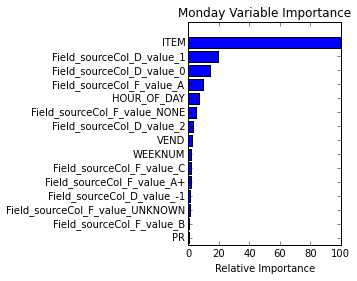

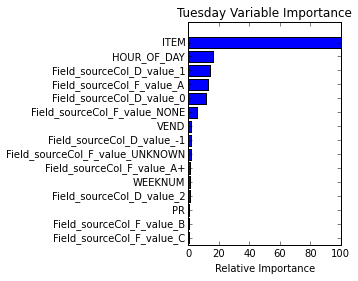

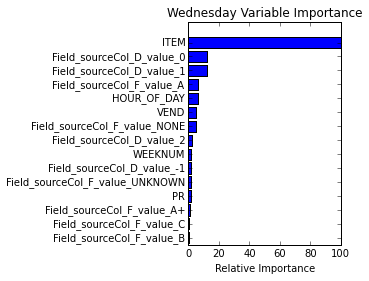

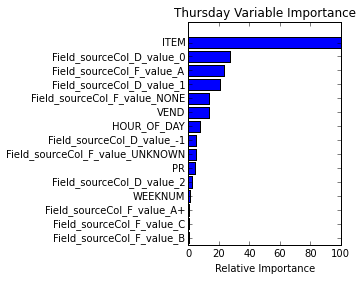

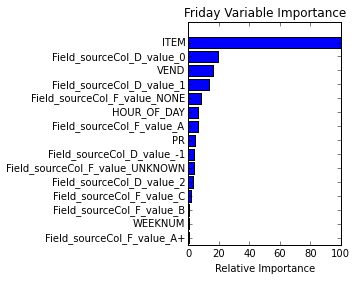

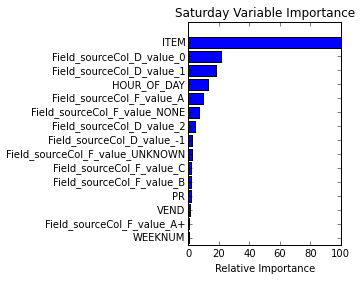

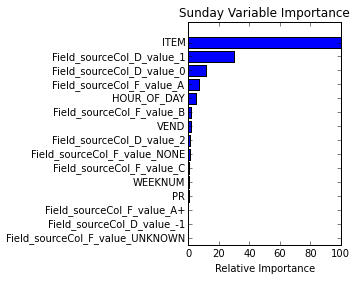

In [101]:
days= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
m_desired_columns_list= []
for i in xrange(0,7):
    m_mask= master_merged_df['DAYOFWEEK'] == i
    a_df = master_merged_df[m_mask]
    a_df= a_df.drop(['DAYOFWEEK'], axis=1)

    m_label_arr= a_df['DOLLARS']
    m_data_arr= a_df.drop([
        'DOLLARS', 
        'UNITS',
        'PANID', 
        'WEEK', 
        'IRI_KEY', 
        'START_TIME_EPOCH_S', 
        'END_TIME_EPOCH_S', 
        'TRANSACTION_TIME_EPOCH_S',
        'COLUPC',
        'DAY',    
        'MINUTE',
        'MONTH',
        'YEAR',
        'SY',
        'GE'
    ], axis=1)
    
    l_columns= m_data_arr.columns
    kbest= SelectKBest(f_regression)
    kbest.fit(m_data_arr, m_label_arr)
    
    m_features= []
    m_scores= []
    for feature, score in zip(l_columns, kbest.scores_):
        m_features.append(feature)
        m_scores.append(score)

    # Plot feature importance
    feature_importance = m_scores
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / np.max(feature_importance))
    sorted_idx = np.argsort(feature_importance)
    pos = list(np.arange(sorted_idx.shape[0]) + .5)

    m_yticks= []
    for j in sorted_idx:
        m_yticks.append(m_features[j])

    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, m_yticks)
    plt.xlabel('Relative Importance')
    plt.title('{} Variable Importance'.format(days[i]))
    plt.show()
    
    desired_columns= m_yticks[-5:]
    m_desired_columns_list.append(desired_columns)

In [102]:
m_master_desired_columns= set()
for l in m_desired_columns_list:
    for i in l:
        m_master_desired_columns.add(i)

m_master_desired_columns= list(m_master_desired_columns)
print "Selected Features"
for c in m_master_desired_columns:
    print c

Selected Features
Field_sourceCol_F_value_NONE
ITEM
VEND
Field_sourceCol_F_value_A
HOUR_OF_DAY
Field_sourceCol_D_value_1
Field_sourceCol_D_value_0


In [103]:
# select Saturday
dayofweek= 5
m_mask= master_merged_df['DAYOFWEEK'] == dayofweek
a_df = master_merged_df[m_mask]
a_df= a_df.drop(['DAYOFWEEK'], axis=1)

m_label_arr= a_df['DOLLARS']
m_data_arr= a_df.drop([
        'DOLLARS', 
        'UNITS',
        'PANID', 
        'WEEK', 
        'IRI_KEY', 
        'START_TIME_EPOCH_S', 
        'END_TIME_EPOCH_S', 
        'TRANSACTION_TIME_EPOCH_S',
        'COLUPC',
        'DAY',    
        'MINUTE',
        'MONTH',
        'YEAR',
        'SY',
        'GE'
    ], axis=1)
m_data_arr= m_data_arr[m_master_desired_columns]
new_mtrain_data, new_mtest_data, new_mtrain_labels, new_mtest_labels = sklearn.cross_validation.train_test_split(m_data_arr, m_label_arr, test_size=0.33, random_state=42)

m_data_arr

,Field_sourceCol_F_value_NONE,ITEM,VEND,Field_sourceCol_F_value_A,HOUR_OF_DAY,Field_sourceCol_D_value_1,Field_sourceCol_D_value_0
6,0,53168,18200,0,13,0,0
38,0,86031,18200,0,10,0,0
49,0,62509,34100,0,18,0,0
53,1,96867,18200,0,13,0,1
72,0,53168,18200,0,16,0,0
79,1,434,52300,0,16,0,1
93,0,435,52300,0,14,0,0
138,0,434,52300,0,9,0,0
158,0,30030,71990,0,13,0,0
170,1,435,52300,0,16,0,1


In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

m_norm_train= scaler.fit_transform(new_mtrain_data)
m_norm_train_target= scaler.fit_transform(new_mtrain_labels)
m_norm_test= scaler.fit_transform(new_mtest_data)
m_norm_test_target= scaler.fit_transform(new_mtest_labels)

In [105]:
def do_plot(predicted, actual_labels, title):
    # Plot
    fig,ax = plt.subplots()
    ax.set_title(title)
    ax.scatter(actual_labels, predicted)
    ax.plot([predicted.min(), predicted.max()], [predicted.min(), predicted.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    fig.show()

LinearRegression score=0.059271289735


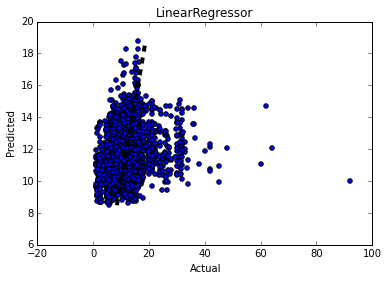

In [106]:
regressor= LinearRegression()
regressor.fit(new_mtrain_data, new_mtrain_labels)
m_score= regressor.score(new_mtest_data, new_mtest_labels)
print "LinearRegression score={}".format(m_score)

# Plot
predicted=regressor.predict(new_mtest_data)
do_plot(predicted, new_mtest_labels, "LinearRegressor")

RidgeRegressor score=0.0595777261791


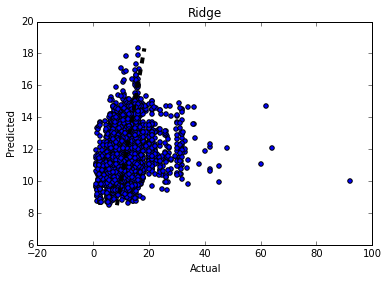

In [107]:
regressor= Ridge(alpha=20.0)
regressor.fit(new_mtrain_data, new_mtrain_labels)
m_score= regressor.score(new_mtest_data, new_mtest_labels)
print "RidgeRegressor score={}".format(m_score)

# Plot
predicted=regressor.predict(new_mtest_data)
do_plot(predicted, new_mtest_labels, "Ridge")

DecisionTreeRegressor score=0.448296055005


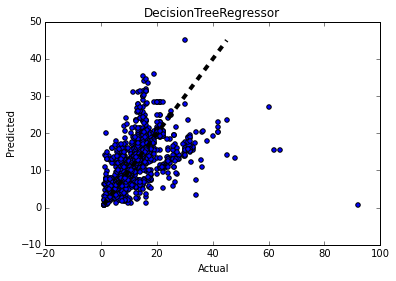

In [108]:
regressor= DecisionTreeRegressor(random_state=42)

regressor.fit(new_mtrain_data, new_mtrain_labels)
m_score= regressor.score(new_mtest_data, new_mtest_labels)
print "DecisionTreeRegressor score={}".format(m_score)

# Plot
predicted=regressor.predict(new_mtest_data)
do_plot(predicted, new_mtest_labels, "DecisionTreeRegressor")

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=7, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=800, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)
RandomForestRegressor score=0.423636010672


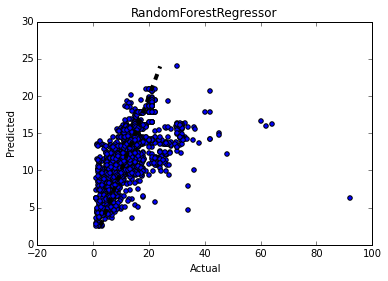

In [109]:
regressor= ensemble.RandomForestRegressor(n_estimators=800, max_depth=7)
print regressor

regressor.fit(new_mtrain_data, new_mtrain_labels)
m_score= regressor.score(new_mtest_data, new_mtest_labels)
print "RandomForestRegressor score={}".format(m_score)

# Plot
predicted=regressor.predict(new_mtest_data)
do_plot(predicted, new_mtest_labels, "RandomForestRegressor")

GradientBoostingRegressor score=0.0283160275437


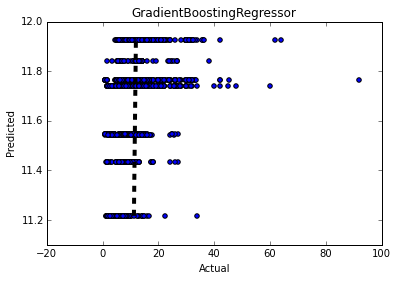

In [110]:
regressor= ensemble.GradientBoostingRegressor(n_estimators=800, learning_rate=0.0001)
regressor.fit(new_mtrain_data, new_mtrain_labels)
m_score= regressor.score(new_mtest_data, new_mtest_labels)
print "GradientBoostingRegressor score={}".format(m_score)

# Plot
predicted=regressor.predict(new_mtest_data)
do_plot(predicted, new_mtest_labels, "GradientBoostingRegressor")

AdaBoostingRegressor score=0.194309895057


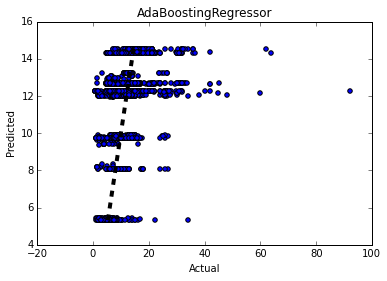

In [111]:
regressor= ensemble.AdaBoostRegressor(n_estimators=800, learning_rate=0.0001)
regressor.fit(new_mtrain_data, new_mtrain_labels)
m_score= regressor.score(new_mtest_data, new_mtest_labels)
print "AdaBoostingRegressor score={}".format(m_score)

# Plot
predicted=regressor.predict(new_mtest_data)
do_plot(predicted, new_mtest_labels, "AdaBoostingRegressor")

Support Vector Machines score=0.150252899178


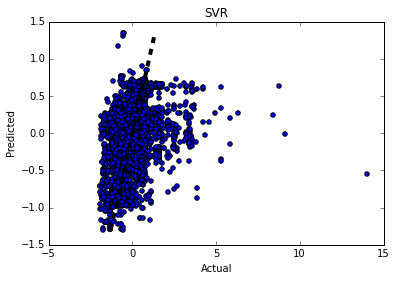

In [112]:
# SVMs require normalization to perform
regressor= SVR()
regressor.fit(m_norm_train, m_norm_train_target)
m_score= regressor.score(m_norm_test, m_norm_test_target)
print "Support Vector Machines score={}".format(m_score)

# Plot
predicted=regressor.predict(m_norm_test)
do_plot(predicted, m_norm_test_target, "SVR")

Nu Support Vector Machines score=0.150353950002


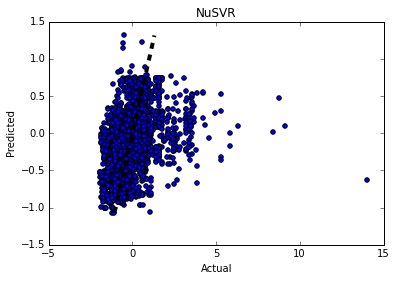

In [113]:
regressor= NuSVR()
regressor.fit(m_norm_train, m_norm_train_target)
m_score= regressor.score(m_norm_test, m_norm_test_target)
print "Nu Support Vector Machines score={}".format(m_score)

# Plot
predicted=regressor.predict(m_norm_test)
do_plot(predicted, m_norm_test_target, "NuSVR")

In [114]:
# Execute stacking
def execute_stacking(new_mtrain_data, new_mtrain_labels, new_mtest_data, new_mtest_labels):
    models = [
        ensemble.RandomForestRegressor(n_estimators=800, max_depth=7),
        DecisionTreeRegressor(random_state=42),
        ensemble.GradientBoostingRegressor(n_estimators=800, learning_rate=0.0001),
        ensemble.AdaBoostRegressor(n_estimators=800, learning_rate=0.0001),
        NuSVR()
    ]
    level0_train = np.zeros((new_mtrain_data.shape[0], len(models)))
    level0_test = np.zeros((new_mtest_data.shape[0], len(models)))
    print new_mtrain_data.shape

    # level 0 - base learners
    kf = list(KFold(len(new_mtrain_labels), 10, shuffle=True, random_state=42))
    for j, model in enumerate(models):
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Regressor")]
        print 'Training regressor {}'.format(model_title)
        level0_test_j = np.zeros((new_mtest_data.shape[0], len(kf))) # Number of testing data x Number of folds , we will take the mean of the predictions later
        for i, (train_index, cv_index) in enumerate(kf):
            print '\tFold {}'.format(i)
    #         print len(new_mtrain_data)
    #         print "train_index=", train_index

            X_train = new_mtrain_data[train_index]
            Y_train = new_mtrain_labels[train_index]
            X_cv = new_mtrain_data[cv_index]

            model.fit(X_train, Y_train)
            level0_train[cv_index, j] = model.predict(X_cv)
            level0_test_j[:, i] = model.predict(new_mtest_data)
        level0_test[:, j] = level0_test_j.mean(1)

    # level 1 - combiner
    combiner= LinearRegression()
    combiner.fit(level0_train, new_mtrain_labels)

    Y_test_predict = combiner.predict(level0_test)
    score = metrics.r2_score(new_mtest_labels, Y_test_predict)
    print 'r2 score = %s' % (score)
    return Y_test_predict

(8606, 7)
Training regressor RandomForest
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor DecisionTree
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor GradientBoosting
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor AdaBoost
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor 
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
r2 score = 0.539386225385


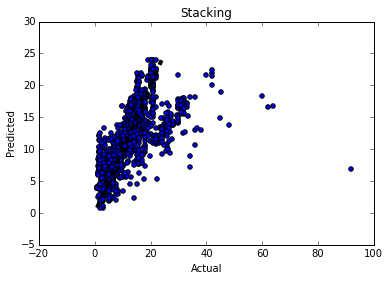

In [115]:
# Plot
predicted= execute_stacking(new_mtrain_data, new_mtrain_labels, new_mtest_data, new_mtest_labels)
do_plot(predicted, new_mtest_labels, "Stacking")

Procssing day Monday
(4784, 7)
Training regressor RandomForest
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor DecisionTree
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor GradientBoosting
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor AdaBoost
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor 
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
r2 score = 0.491857765757
Procssing day Tuesday
(4809, 7)
Training regressor RandomForest
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor DecisionTree
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor GradientBoosting
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor AdaB

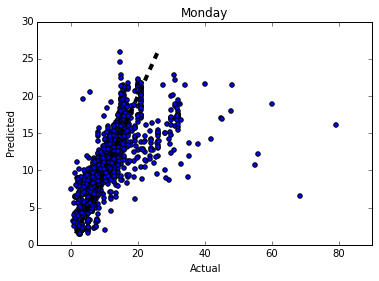

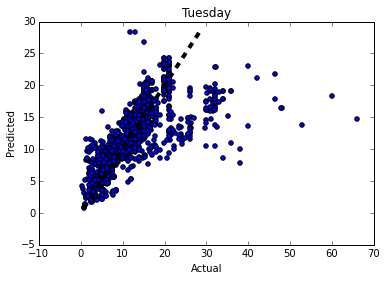

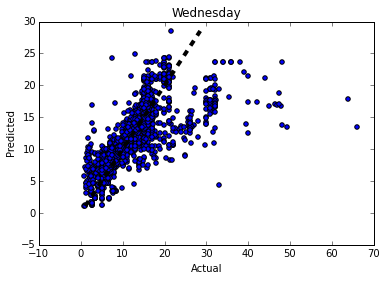

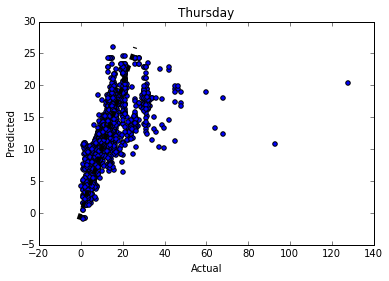

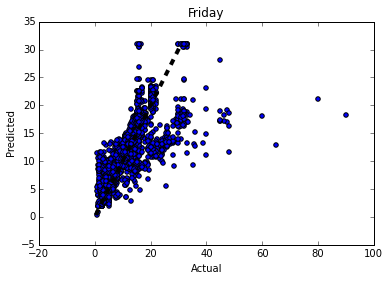

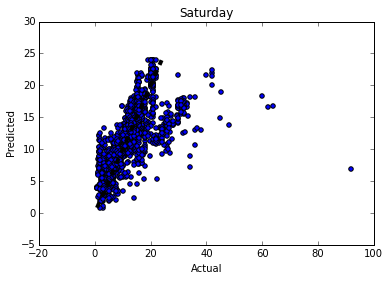

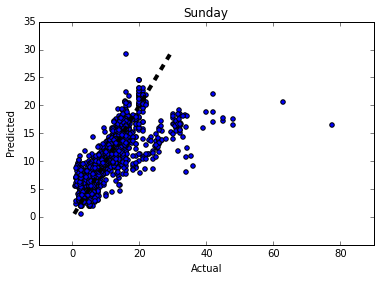

In [116]:
# Run Stacking Ensemble for all Days
day_labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in xrange(7):
    print "Procssing day {}".format(day_labels[i])
    m_mask= master_merged_df['DAYOFWEEK'] == i
    a_df = master_merged_df[m_mask]
    a_df= a_df.drop(['DAYOFWEEK'], axis=1)

    m_label_arr= a_df['DOLLARS']
    m_data_arr= a_df.drop([
            'DOLLARS', 
            'UNITS',
            'PANID', 
            'WEEK', 
            'IRI_KEY', 
            'START_TIME_EPOCH_S', 
            'END_TIME_EPOCH_S', 
            'TRANSACTION_TIME_EPOCH_S',
            'COLUPC',
            'DAY',    
            'MINUTE',
            'MONTH',
            'YEAR',
            'SY',
            'GE'
        ], axis=1)
    m_data_arr= m_data_arr[m_master_desired_columns]
    
    new_mtrain_data, new_mtest_data, new_mtrain_labels, new_mtest_labels = sklearn.cross_validation.train_test_split(m_data_arr, m_label_arr, test_size=0.33, random_state=42)
    predicted= execute_stacking(new_mtrain_data, new_mtrain_labels, new_mtest_data, new_mtest_labels)
    do_plot(predicted, new_mtest_labels, day_labels[i])

# Consider Deep Promotion Periods

In [117]:
# Consider Deep Promotion Periods
m_masks= []

# no promotion
m_masks.append((master_merged_df['PR'] == 0))
m_masks.append((master_merged_df['Field_sourceCol_F_value_NONE'] == 1))
m_masks.append((master_merged_df['Field_sourceCol_D_value_0'] == 1))

a_df= master_merged_df.copy()
for mask in m_masks:
    a_df= a_df[mask]

no_promotions_df= a_df
no_promotions_df.groupby('DAYOFWEEK').size()

DAYOFWEEK
0            1578
1            1731
2            1968
3            2427
4            3056
5            2670
6            1664
dtype: int64

In [118]:
a_df= master_merged_df.copy()
for mask in m_masks:
    a_df= a_df[~mask]

m_masks2= []
m_masks2.append((master_merged_df['Field_sourceCol_F_value_UNKNOWN'] == 0))

for mask in m_masks2:
    a_df= a_df[mask]

promotions_df= a_df
promotions_df.groupby('DAYOFWEEK').size()

DAYOFWEEK
0            58
1            55
2            77
3            74
4            89
5            72
6            38
dtype: int64

In [119]:
print "Total number of no promotion transactions", len(no_promotions_df)

no_prom_store=no_promotions_df.groupby('IRI_KEY').size()
no_prom_store.sort(inplace=True)
no_prom_store.tail()

Total number of no promotion transactions 15094


IRI_KEY
257871     5403
1085053    9691
dtype: int64

In [120]:
print "Total number of promotion transactions", len(promotions_df)

prom_store=promotions_df.groupby('IRI_KEY').size()
prom_store.sort(inplace=True)
prom_store.tail()

Total number of promotion transactions 463


IRI_KEY
1085053     30
257871     433
dtype: int64

In [121]:
no_prom_store_sample= no_promotions_df[no_promotions_df['IRI_KEY'] == 257871]
prom_store_sample= promotions_df[promotions_df['IRI_KEY'] == 257871]

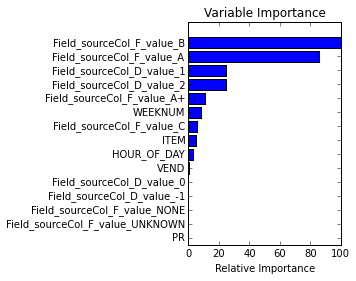

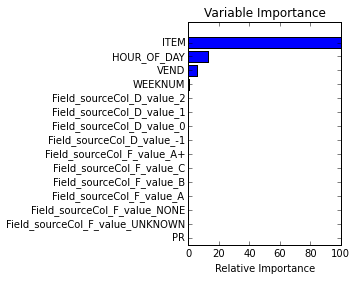

Selected Features
ITEM
Field_sourceCol_F_value_A+
Field_sourceCol_F_value_B
Field_sourceCol_F_value_A
HOUR_OF_DAY
Field_sourceCol_D_value_1
VEND
Field_sourceCol_D_value_2
WEEKNUM


In [122]:
import math

dfs= [promotions_df, no_promotions_df]
m_desired_columns_list= []
for a_df in dfs:
    a_df= a_df.drop(['DAYOFWEEK'], axis=1)

    m_label_arr= a_df['DOLLARS']
    m_data_arr= a_df.drop([
        'DOLLARS', 
        'UNITS',
        'PANID', 
        'WEEK', 
        'IRI_KEY', 
        'START_TIME_EPOCH_S', 
        'END_TIME_EPOCH_S', 
        'TRANSACTION_TIME_EPOCH_S',
        'COLUPC',
        'DAY',    
        'MINUTE',
        'MONTH',
        'YEAR',
        'SY',
        'GE'
    ], axis=1)
    l_columns= m_data_arr.columns
    kbest= SelectKBest(f_regression)
    kbest.fit(m_data_arr, m_label_arr)

    m_features= []
    m_scores= []
    for feature, score in zip(l_columns, kbest.scores_):
        m_features.append(feature)
        if math.isnan(score):
            score= 0.
        m_scores.append(score)

    # Plot feature importance
    feature_importance = m_scores
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / np.max(feature_importance))
    sorted_idx = np.argsort(feature_importance)
    pos = list(np.arange(sorted_idx.shape[0]) + .5)

    m_yticks= []
    for j in sorted_idx:
        m_yticks.append(m_features[j])

    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, m_yticks)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    desired_columns= m_yticks[-5:]
    m_desired_columns_list.append(desired_columns)

m_master_desired_columns= set()
for l in m_desired_columns_list:
    for i in l:
        m_master_desired_columns.add(i)

m_master_desired_columns= list(m_master_desired_columns)
print "Selected Features"
for c in m_master_desired_columns:
    print c

In [123]:
a_df = no_prom_store_sample
a_df= a_df.drop(['DAYOFWEEK'], axis=1)

m_label_arr= a_df['DOLLARS']
m_data_arr= a_df.drop([
    'DOLLARS', 
    'UNITS',
    'PANID', 
    'WEEK', 
    'IRI_KEY', 
    'START_TIME_EPOCH_S', 
    'END_TIME_EPOCH_S', 
    'TRANSACTION_TIME_EPOCH_S',
    'COLUPC',
    'DAY',    
    'MINUTE',
    'MONTH',
    'YEAR',
    'SY',
    'GE'
], axis=1)

m_data_arr= m_data_arr[m_master_desired_columns]
new_mtrain_data, new_mtest_data, new_mtrain_labels, new_mtest_labels = sklearn.cross_validation.train_test_split(m_data_arr, m_label_arr, test_size=0.33, random_state=42)

In [124]:
predicted= execute_stacking(new_mtrain_data, new_mtrain_labels, new_mtest_data, new_mtest_labels)
no_promotion_predicted=predicted
no_promotion_actual=new_mtest_labels

(3620, 9)
Training regressor RandomForest
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor DecisionTree
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor GradientBoosting
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor AdaBoost
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor 
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
r2 score = 0.467130036893


In [126]:
# combine nopromo with promo and predict
m_nopromo_promo_combined= no_promotions_df.append(promotions_df, ignore_index=True)
a_df = m_nopromo_promo_combined
a_df= a_df.drop(['DAYOFWEEK'], axis=1)

m_label_arr= a_df['DOLLARS']
m_data_arr= a_df.drop([
    'DOLLARS', 
    'UNITS',
    'PANID', 
    'WEEK', 
    'IRI_KEY', 
    'START_TIME_EPOCH_S', 
    'END_TIME_EPOCH_S', 
    'TRANSACTION_TIME_EPOCH_S',
    'COLUPC',
    'DAY',    
    'MINUTE',
    'MONTH',
    'YEAR',
    'SY',
    'GE'
], axis=1)

m_data_arr= m_data_arr[m_master_desired_columns]
new_mtrain_data, new_mtest_data, new_mtrain_labels, new_mtest_labels = sklearn.cross_validation.train_test_split(m_data_arr, m_label_arr, test_size=0.33, random_state=42)

In [127]:
predicted= execute_stacking(new_mtrain_data, new_mtrain_labels, new_mtest_data, new_mtest_labels)
promo_no_promotion_predicted=predicted
promo_no_promotion_actual=new_mtest_labels

(10423, 9)
Training regressor RandomForest
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor DecisionTree
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor GradientBoosting
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor AdaBoost
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
Training regressor 
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Fold 4
	Fold 5
	Fold 6
	Fold 7
	Fold 8
	Fold 9
r2 score = 0.498634100492


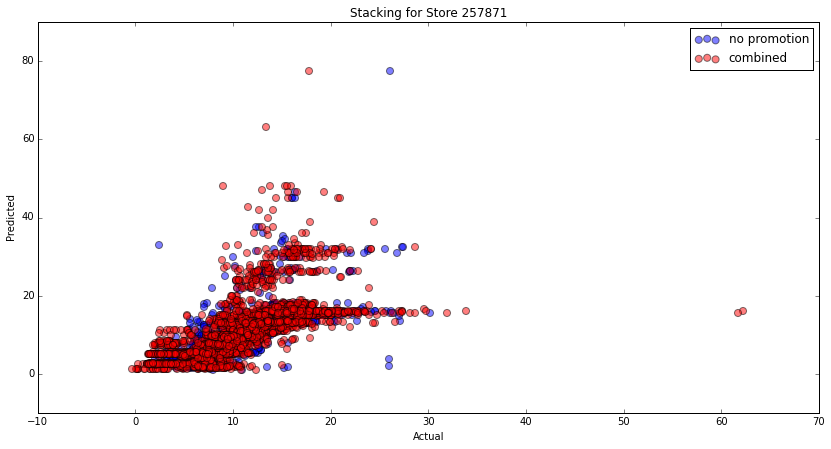

In [129]:
fig,ax = plt.subplots(figsize=(14,7))
ax.scatter(no_promotion_predicted, no_promotion_actual, c='b', label="no promotion", alpha=0.5, s=50)
ax.scatter(promo_no_promotion_predicted, promo_no_promotion_actual, c='r', label="combined", alpha=0.5, s=50)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()
ax.set_title("Stacking for Store 257871")
fig.show()